# Pseudo Labeling with QDA scores LB 0.969
Roman posted a kernel introducing pseudo labeling [here][1]. I would like to explain why it works, make a few improvements, and demonstrate the power of this technique! This kernel is the same as my support vector machine kernel [here][2] with QDA and pseudo labeling added. It achieves an impresive CV 0.970 and LB 0.969

In Santander's Customer Transaction competition, team Wizardry used pseudo labeling to increase their private LB by 0.0005 allowing them to beat second place by 0.0002 for the $25,000 prize! [here][3]

In "Instant Gratification" competition, we are building 512 models where each model's train data has approximately 512 rows and 40 columns. With 40 variables, a quadratic model would like more rows. With pseudo labeling, we can get an additional 400 rows of training data and increase CV and LB by 0.005!

[1]: https://www.kaggle.com/nroman/i-m-overfitting-and-i-know-it/notebook
[2]: https://www.kaggle.com/cdeotte/support-vector-machine-0-925
[3]: https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89003

# What is Pseudo Labeling?
Pseudo labeling is the process of adding confident predicted test data to your training data. Pseudo labeling is a 5 step process. (1) Build a model using training data. (2) Predict labels for an unseen test dataset. (3) Add confident predicted test observations to our training data (4) Build a new model using combined data. And (5) use your new model to predict the test data and submit to Kaggle. Here is a pictorial explanation using sythetic 2D data. 
  
## Step 1 - Build first model
Given 50 training observations (25 target=1 yellow points, 25 target=0 blue points) build a model using QDA. Notice how QDA calculates the two multivariate Gaussian distributions that the target=1 and target=0 were drawn from. QDA's approximation is represented as ellipses of 1, 2, 3 standard deviations for each distribution.

![image](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/p16419.png)

## Step 2 - Predict test data
Using our model (ellipses), predict the target of 50 unknown data points. The bottom picture shows the decisions made by our classifier.

![image](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/p26419.png)

![image](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/p36419.png)

## Step 3 and 4 - Add pseudo label data and build second model
Add all predictions with `Pr(y=1|x)>0.99` and `Pr(y=0|x)>0.99` to our training data. Then train a new model using the combined 90 points with QDA. The red ellipses show QDA's new approximation of the two Gaussian distributions. This time QDA has found better ellipses then before.

![image](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/p46419.png)

## Step 5 - Predict test data
Finally use our more accurate QDA ellipses to predict test (a second time) and submit to Kaggle.

# Why does Pseudo Labeling work?
When I first learned about pseudo labeling (from team Wizardry's 1st place solution [here][1]), I was surprised that it could increase a model's accuracy. How does training with unknown data that has been labeled by a model improve that same model? Doesn't the model already know the information? Because the model made those predictions.

How pseudo labeling works is best understood with QDA. QDA works by using points in p-dimensional space to find hyper-ellipsoids, see [here][2]. With more points, QDA can better estimate the center and shape of each ellipsoid (and consequently make better preditions afterward).

Pseudo labeling helps all types of models because all models can be visualized as finding shapes of target=1 and target=0 in p-dimensional space. See [here][3] for examples. More points allow for better estimation of shapes.

[1]: https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89003
[2]: https://www.kaggle.com/c/instant-gratification/discussion/93843
[3]: https://www.kaggle.com/c/instant-gratification/discussion/94179

# Apply Pseudo Labeling to Instant Gratification Comp
## Load Data

In [7]:
import numpy as np, pandas as pd, os
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [8]:
train

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [9]:
test

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
0,ba88c155ba898fc8b5099893036ef205,-0.155789,0.761549,1.156785,-0.272358,-1.302155,1.560988,-1.815729,-0.702968,0.435537,1.283895,-0.343518,-1.838579,-0.042550,-0.445104,-1.095100,0.705350,-0.380414,-0.795682,-0.758300,-0.414352,-0.777386,-1.161663,0.066044,-1.344336,1.093101,0.050480,-0.237973,-1.909876,2.958334,0.500903,-0.279001,-0.119306,1.211495,-0.755415,0.033202,-1.496447,1.361191,0.934949,1.664903,...,1.105099,-1.039678,-0.020976,-2.549582,-0.042384,-0.080888,-1.337010,-0.454110,0.147896,1.429689,1.568941,-0.708524,-1.353830,-1.022430,0.223778,0.584740,-1.115830,1.620426,-0.806678,0.649135,-0.052494,-0.947633,2.981762,-2.321268,0.106400,-0.350618,-0.121869,-0.898826,-0.751598,-0.732516,-4.207352,0.404394,0.695667,0.515584,1.339533,2.005131,-1.832629,-0.454067,-0.204909,-0.314752
1,7cbab5cea99169139e7e6d8ff74ebb77,-4.528525,-0.158527,0.616473,-0.172137,1.255351,0.064565,-1.124906,-1.826855,-1.429915,-0.777585,-0.250756,-0.416648,-0.142929,-0.977553,1.384768,2.393905,-1.913877,1.145628,-1.145112,-0.502978,1.200528,-6.464249,-0.427974,0.656148,-1.808154,-1.039081,-0.604521,2.109838,5.174223,-0.352850,7.710951,0.442175,-0.752437,-0.757275,0.535649,3.085409,1.297368,-2.859359,-1.626998,...,0.041613,-6.718112,-0.562997,0.224132,-0.896035,0.275753,-0.932541,0.279365,-0.491741,0.451097,-0.269904,-0.825188,-0.505424,-0.955194,-0.394282,0.853037,0.521197,2.146393,-0.520788,-1.047142,-2.104112,-0.647331,3.002434,0.249064,0.923207,1.169519,-0.914550,-0.152553,1.291979,0.344865,-0.219057,-1.473936,-1.230680,2.064435,-0.297421,-0.499721,0.138128,-1.674848,-2.368582,0.185971
2,7baaf361537fbd8a1aaa2c97a6d4ccc7,1.807488,-0.

In [10]:
train.columns

Index(['id', 'muggy-smalt-axolotl-pembus', 'dorky-peach-sheepdog-ordinal',
       'slimy-seashell-cassowary-goose',
       'snazzy-harlequin-chicken-distraction', 'frumpy-smalt-mau-ordinal',
       'stealthy-beige-pinscher-golden', 'chummy-cream-tarantula-entropy',
       'hazy-emerald-cuttlefish-unsorted', 'nerdy-indigo-wolfhound-sorted',
       ...
       'wheezy-myrtle-mandrill-entropy', 'wiggy-lilac-lemming-sorted',
       'gloppy-cerise-snail-contributor', 'woozy-silver-havanese-gaussian',
       'jumpy-thistle-discus-sorted', 'muggy-turquoise-donkey-important',
       'blurry-buff-hyena-entropy', 'bluesy-chocolate-kudu-fepid',
       'gamy-white-monster-expert', 'target'],
      dtype='object', length=258)

In [11]:
test.columns

Index(['id', 'muggy-smalt-axolotl-pembus', 'dorky-peach-sheepdog-ordinal',
       'slimy-seashell-cassowary-goose',
       'snazzy-harlequin-chicken-distraction', 'frumpy-smalt-mau-ordinal',
       'stealthy-beige-pinscher-golden', 'chummy-cream-tarantula-entropy',
       'hazy-emerald-cuttlefish-unsorted', 'nerdy-indigo-wolfhound-sorted',
       ...
       'goopy-lavender-wolverine-fimbus', 'wheezy-myrtle-mandrill-entropy',
       'wiggy-lilac-lemming-sorted', 'gloppy-cerise-snail-contributor',
       'woozy-silver-havanese-gaussian', 'jumpy-thistle-discus-sorted',
       'muggy-turquoise-donkey-important', 'blurry-buff-hyena-entropy',
       'bluesy-chocolate-kudu-fepid', 'gamy-white-monster-expert'],
      dtype='object', length=257)

In [12]:
train_columns = set(train.columns)
test_columns = set(test.columns)

# Differences
train_only_columns = train_columns - test_columns
test_only_columns = test_columns - train_columns

print("Columns in train but not in test:", train_only_columns)
# Output: {'feature2', 'target'}

print("Columns in test but not in train:", test_only_columns)
# Output: {'feature3'}

print('Number of Columns in Train: ', len(train_columns))
print('Number of Columns in Test: ', len(test_columns))

Columns in train but not in test: {'target'}
Columns in test but not in train: set()
Number of Columns in Train:  258
Number of Columns in Test:  257


# Step 1 and 2 - Build first QDA model and predict test

In [16]:
# Select feature columns, excluding irrelevant columns.
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')

# Initialize arrays for storing predictions:
# oof: Out-of-fold predictions for training data.
# preds: Predictions for test data.
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# Display initialized variables
print("Number of features:", len(cols))
print("Shape of oof array:", oof.shape)
print("Shape of preds array:", preds.shape)

Number of features: 255
Shape of oof array: (262144,)
Shape of preds array: (131072,)


In [17]:
for i in range(512):
    # Subset data for the current value of 'wheezy-copper-turtle-magic'
    train2 = train[train['wheezy-copper-turtle-magic'] == i]
    test2 = test[test['wheezy-copper-turtle-magic'] == i]

    # Skip if no data exists for this group
    if len(train2) == 0 and len(test2) == 0:
        continue

    # Save indices for storing predictions
    idx1 = train2.index
    idx2 = test2.index

    # Reset index for easier processing
    train2.reset_index(drop=True, inplace=True)

    # Display preview for this group
    print(f"Processing group {i}")
    print(f"Number of training samples in group {i}: {len(train2)}")
    print(f"Number of test samples in group {i}: {len(test2)}")
    break  # Break after processing the first group to preview output

Processing group 0
Number of training samples in group 0: 534
Number of test samples in group 0: 0


In [18]:
# Apply VarianceThreshold to remove low-variance features
sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
train3 = sel.transform(train2[cols])
if len(test2) > 0:
    test3 = sel.transform(test2[cols])

# Display feature selection results
print("Original number of features:", len(cols))
print("Number of features after selection:", train3.shape[1])

Original number of features: 255
Number of features after selection: 46


In [19]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)

# Loop through the folds and display training/validation split sizes
for fold, (train_index, test_index) in enumerate(skf.split(train3, train2['target'])):
    print(f"Fold {fold + 1}:")
    print(f" - Training samples: {len(train_index)}")
    print(f" - Validation samples: {len(test_index)}")
    break  # Break after processing the first fold to preview output

Fold 1:
 - Training samples: 485
 - Validation samples: 49


In [20]:
# Initialize QDA model
clf = QuadraticDiscriminantAnalysis(reg_param=0.5)

# Train the model on the training split
clf.fit(train3[train_index, :], train2.loc[train_index, 'target'])

# Predict probabilities for the validation split
val_preds = clf.predict_proba(train3[test_index, :])[:, 1]
print("Validation predictions (first 5):", val_preds[:5])

# Predict probabilities for test data if it exists
if len(test2) > 0:
    test_preds = clf.predict_proba(test3)[:, 1]
    print("Test predictions (first 5):", test_preds[:5])

Validation predictions (first 5): [8.30958715e-15 1.00000000e+00 5.93872486e-17 9.99996327e-01
 9.99999903e-01]


In [21]:
# Store out-of-fold predictions for validation data
oof[idx1[test_index]] = val_preds

# Accumulate test predictions (average across folds)
if len(test2) > 0:
    preds[idx2] += test_preds / skf.n_splits

In [22]:
# Calculate the AUC score
auc = roc_auc_score(train['target'], oof)
print("QDA scores CV =", round(auc, 5))

QDA scores CV = 0.5


In [23]:
# INITIALIZE VARIABLES

# Select columns to use for training, excluding 'id', 'target', and 'wheezy-copper-turtle-magic'.
# 'id' is likely an identifier, 'target' is the label, and 'wheezy-copper-turtle-magic' is used for grouping.
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')

# Initialize arrays to store predictions:
# - oof: Out-of-fold predictions for the training data (for model evaluation).
# - preds: Predictions for the test data (to combine results across folds).
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS

# Loop through each unique value (0-511) of the 'wheezy-copper-turtle-magic' feature.
# This creates 512 separate models, one for each subset of data where 'wheezy-copper-turtle-magic' is constant.
for i in range(512):
    # Subset training and testing data where 'wheezy-copper-turtle-magic' equals the current value of `i`.
    train2 = train[train['wheezy-copper-turtle-magic'] == i]
    test2 = test[test['wheezy-copper-turtle-magic'] == i]
    
    # Skip this iteration if both subsets are empty (no relevant data for this group).
    if (len(train2) == 0) & (len(test2) == 0): continue
    
    # Save the original indices of the current subsets for storing predictions later.
    idx1 = train2.index
    idx2 = test2.index
    
    # Reset the index of the training subset for cleaner processing.
    train2.reset_index(drop=True, inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)

    # Apply VarianceThreshold to remove low-variance features within the current subset.
    # This reduces the dimensionality of the data by keeping only features with variance > 1.5.
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    
    # Transform the training data to keep only selected high-variance features.
    train3 = sel.transform(train2[cols])
    
    # Similarly, transform the test data (if it exists) to align features with the training data.
    if len(test2) > 0:
        test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD

    # Use Stratified K-Fold Cross-Validation with 11 splits.
    # This ensures class distribution is preserved in each fold for training and validation.
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    
    # Loop through each fold's train-test split.
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH QDA

        # Initialize the Quadratic Discriminant Analysis (QDA) model with a regularization parameter of 0.5.
        # The regularization parameter helps prevent overfitting.
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        
        # Train the QDA model on the training split of the current fold.
        clf.fit(train3[train_index, :], train2.loc[train_index]['target'])
        
        # Predict probabilities for the validation split of the current fold.
        # Store the probabilities for the positive class (class 1) in the corresponding indices of `oof`.
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index, :])[:, 1]
        
        # Predict probabilities for the test data (if it exists).
        # Accumulate the probabilities for the positive class across all folds.
        # Average the probabilities by dividing by the number of splits.
        if len(test2) > 0:
            preds[idx2] += clf.predict_proba(test3)[:, 1] / skf.n_splits

    # Optional: Print progress every 64 iterations (debugging/monitoring purposes).
    # if i % 64 == 0:
    #     print(i)

# PRINT CV AUC

# Calculate the Area Under the ROC Curve (AUC) score for the training data predictions (`oof`).
# This measures the model's performance during cross-validation.
auc = roc_auc_score(train['target'], oof)

# Print the final AUC score rounded to 5 decimal places.
print('QDA scores CV =', round(auc, 5))
# QDA scores CV = 0.96541

QDA scores CV = 0.96541


# Step 3 & 4 - Add pseudo label data and build second model 

In [24]:
# Initialize test predictions with current predictions (if any exist).
test['target'] = preds

# Create arrays for predictions:
# oof: Out-of-fold predictions for training data.
# preds: Predictions for test data.
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# Display initialization outputs
print(f"Initialized oof array with shape: {oof.shape}")
print(f"Initialized preds array with shape: {preds.shape}")

Initialized oof array with shape: (262144,)
Initialized preds array with shape: (131072,)


In [25]:
for k in range(512):
    # Subset data for the current group
    train2 = train[train['wheezy-copper-turtle-magic'] == k]
    test2 = test[test['wheezy-copper-turtle-magic'] == k]
    
    # Skip groups with no data in both train and test sets
    if len(train2) == 0 and len(test2) == 0:
        continue
    
    # Save indices for storing predictions
    idx1 = train2.index
    idx2 = test2.index
    
    # Display the size of the current subset
    print(f"Processing group {k}:")
    print(f" - Training samples: {len(train2)}")
    print(f" - Test samples: {len(test2)}")
    break  # Stop after the first group for demonstration

Processing group 0:
 - Training samples: 534
 - Test samples: 0


In [26]:
# Select high-confidence pseudo-labeled test samples
test2p = test2[(test2['target'] <= 0.01) | (test2['target'] >= 0.99)].copy()

# Assign pseudo labels based on confidence
test2p.loc[test2p['target'] >= 0.5, 'target'] = 1
test2p.loc[test2p['target'] < 0.5, 'target'] = 0

# Combine original training data with pseudo-labeled test data
train2p = pd.concat([train2, test2p], axis=0)
train2p.reset_index(drop=True, inplace=True)

# Display the size of the combined training set
print(f" - Combined training samples (original + pseudo-labeled): {len(train2p)}")

 - Combined training samples (original + pseudo-labeled): 534


In [27]:
# Apply VarianceThreshold to the combined training set
sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])

# Transform training and test data
train3p = sel.transform(train2p[cols])  # Combined training data
train3 = sel.transform(train2[cols])   # Original training data
if len(test2) > 0:
    test3 = sel.transform(test2[cols]) # Test data

# Display the number of features selected
print(f" - Original number of features: {len(cols)}")
print(f" - Number of features after selection: {train3p.shape[1]}")

 - Original number of features: 255
 - Number of features after selection: 46


In [28]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)

# Loop through folds
for fold, (train_index, test_index) in enumerate(skf.split(train3p, train2p['target'])):
    # Exclude pseudo-labeled data from out-of-fold predictions
    test_index3 = test_index[test_index < len(train3)]
    
    # Train QDA model
    clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
    clf.fit(train3p[train_index, :], train2p.loc[train_index, 'target'])
    
    # Predict on validation set and store in `oof`
    oof[idx1[test_index3]] = clf.predict_proba(train3[test_index3, :])[:, 1]
    
    # Predict on test set and accumulate results
    if len(test2) > 0:
        preds[idx2] += clf.predict_proba(test3)[:, 1] / skf.n_splits
    
    # Display fold-level details
    print(f" - Fold {fold + 1}:")
    print(f"   - Training samples: {len(train_index)}")
    print(f"   - Validation samples: {len(test_index3)}")
    break  # Stop after the first fold for demonstration

 - Fold 1:
   - Training samples: 485
   - Validation samples: 49


In [29]:
# Calculate AUC for out-of-fold predictions
auc = roc_auc_score(train['target'], oof)
print(f"Pseudo-Labeled QDA CV AUC Score: {round(auc, 5)}")

Pseudo-Labeled QDA CV AUC Score: 0.5


In [30]:
# INITIALIZE VARIABLES

# Initialize test predictions with the current predictions stored in `preds` (assumes they were generated previously).
test['target'] = preds

# Create arrays to store predictions:
# - oof: Out-of-fold predictions for the training data.
# - preds: Predictions for the test data, initialized to zeros for accumulation.
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS

# Loop through each unique value (0-511) of the `wheezy-copper-turtle-magic` feature.
# A separate model is built for each subset of data where `wheezy-copper-turtle-magic` equals `k`.
for k in range(512):
    # Subset the training data where 'wheezy-copper-turtle-magic' equals `k`.
    train2 = train[train['wheezy-copper-turtle-magic'] == k]
    
    # Copy the training subset and save its original indices.
    train2p = train2.copy()
    idx1 = train2.index
    
    # Subset the test data where 'wheezy-copper-turtle-magic' equals `k`.
    test2 = test[test['wheezy-copper-turtle-magic'] == k]
    
    # ADD PSEUDO LABELED DATA
    
    # Select test samples with high-confidence predictions (probability ≤ 0.01 or ≥ 0.99).
    # These are considered "pseudo-labeled" because their predicted labels are deemed reliable.
    test2p = test2[(test2['target'] <= 0.01) | (test2['target'] >= 0.99)].copy()
    
    # Assign pseudo labels:
    # - Samples with probabilities ≥ 0.5 are labeled as 1 (class 1).
    # - Samples with probabilities < 0.5 are labeled as 0 (class 0).
    test2p.loc[test2p['target'] >= 0.5, 'target'] = 1
    test2p.loc[test2p['target'] < 0.5, 'target'] = 0
    
    # Combine the original training subset with the pseudo-labeled test data.
    train2p = pd.concat([train2p, test2p], axis=0)
    
    # Reset the index of the combined training dataset for consistency.
    train2p.reset_index(drop=True, inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    
    # Use VarianceThreshold to remove low-variance features (variance ≤ 1.5) from the combined training data.
    # This helps reduce dimensionality and focus on more informative features.
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])
    
    # Transform the datasets:
    # - train3p: Combined training data (original + pseudo-labeled) after feature selection.
    # - train3: Original training data (without pseudo-labeled samples) after feature selection.
    # - test3: Test data after feature selection (if not empty).
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    if len(test2) > 0:
        test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    
    # Use Stratified K-Fold Cross-Validation with 11 splits.
    # Ensures class distribution is preserved across training and validation splits.
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    
    # Loop through each fold's train-test split.
    for train_index, test_index in skf.split(train3p, train2p['target']):
        # Exclude pseudo-labeled data from out-of-fold predictions:
        # Only include indices corresponding to the original training data.
        test_index3 = test_index[test_index < len(train3)]
        
        # MODEL AND PREDICT WITH QDA
        
        # Initialize the Quadratic Discriminant Analysis (QDA) model with a regularization parameter of 0.5.
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        
        # Train the QDA model on the combined training data (original + pseudo-labeled) for the current fold.
        clf.fit(train3p[train_index, :], train2p.loc[train_index]['target'])
        
        # Predict probabilities for the validation fold (original training data only).
        # Store the probabilities for the positive class (class 1) in the `oof` array.
        oof[idx1[test_index3]] = clf.predict_proba(train3[test_index3, :])[:, 1]
        
        # Predict probabilities for the test data (if it exists).
        # Accumulate the probabilities for the positive class across all folds, averaging them later.
        if len(test2) > 0:
            preds[test2.index] += clf.predict_proba(test3)[:, 1] / skf.n_splits
    
    # Optional: Print progress every 64 iterations (for monitoring/debugging purposes).
    # if k % 64 == 0:
    #     print(k)

# PRINT CV AUC

# Calculate the Area Under the ROC Curve (AUC) score for the out-of-fold predictions (`oof`).
# This evaluates the model's performance during cross-validation.
auc = roc_auc_score(train['target'], oof)

# Print the final AUC score rounded to 5 decimal places.
print('Pseudo Labeled QDA scores CV =', round(auc, 5))

# Pseudo Labeled QDA scores CV = 0.9679

Pseudo Labeled QDA scores CV = 0.94594


# Submit Predictions

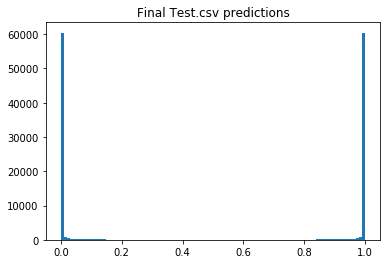

In [15]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Final Test.csv predictions')
plt.show()

# Conclusion
In this kernel, we learned what pseudo labeling is, why it works, and how to deploy it. Using it on the data from Instant Gratification competition we observed it increase CV by an impressive 0.005! Pseudo labeling QDA achieved CV 0.970 and LB 0.969. Without pseudo labeling, QDA achieved CV 0.965 and LB 0.965.

When you run your kernel locally, it will only pseudo label the public test data (because that is all that `test.csv` contains). When you submit this solution to Kaggle, your submission will load the full `test.csv` and pseudo label both the public and private test data set. Thus you will approximately double your amount of training data for your submissions!